# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Wed Oct  6 15:08:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8    15W / 240W |    455MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [1]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [16:00:37] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
dataset = 'CHEMBL205_cl'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}.csv')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl-data-with-ecfp-activations.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/RdkitDescriptors.py'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240_cl.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_512.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218_cl_ecfp_1024.csv'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301_cl_ecfp_1024.cs

In [6]:
DATA = path/'mol_images'

In [7]:
IMAGES = DATA/dataset

In [10]:
df.head()

,CID,SMILES,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc...,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O...,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1


# Create train validation split

In [8]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=666, stratify=df['Activity'])
df.loc[x_train, 'is_valid']=False
df.loc[x_valid, 'is_valid']=True

In [13]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

# Create dataloader

In [9]:
from fastai.vision.all import *

In [15]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [16]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [10]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [11]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=batch_tfms,
    )

In [12]:
def get_dls(dataset, df, random_state=42, test_size=0.2, bs=64):
    IMAGES = DATA/dataset
    x_train, x_valid = train_test_split(df.index, test_size=0.2, random_state=random_state, stratify=df['Activity'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['CID'] + '.png'
    images = df['CID'] + ".png"
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=batch_tfms,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True)
    return dls

In [20]:
dls = get_dls(dataset, df, random_state=42)

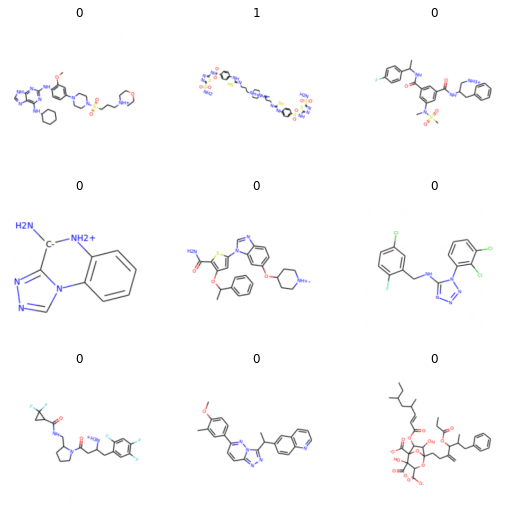

In [21]:
dls.show_batch()

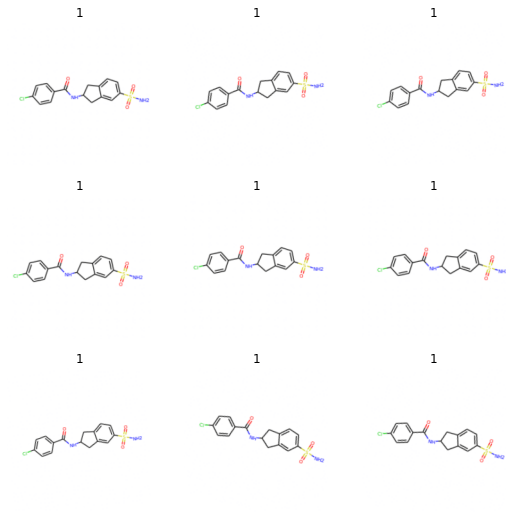

In [22]:
dls.show_batch(unique=True)

# Create class weights

In [23]:
TARGET = 'Activity'

In [24]:
class_count_df = df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,16310,16310,16310,16310
1,1631,1631,1631,1631


In [25]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [26]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.55, 5.5)

In [27]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [28]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [13]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [30]:
loss_func=get_loss_func(df)

# Train CNN model

In [31]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [15]:
def train_model(dls, arch=resnet18, loss_func=None, epochs=16, wd=None, lr=None):
    
    
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [33]:
# Train model on resnet18
learn = train_model(dls, epochs=30, lr=3e-3, wd=0.002)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=30
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(k=5)

# Test different regularizations

## Results:
### wd = 0.002 is good for around 15-20 epochs
### lr = 3e-3 is good for most CNNs and also in this case
### dropout = 0.5 is a usually sustainable

In [16]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# wd = 0.002 works for around 15-20 epochs
# lr = 3e-3 is good most CNN and in this case
# dropout = 0.5 is a usually sustainable
param_grid={
    "wd" : [0.001, 0.002, 0.005, 0.01, 0.02],
}
param_grid = ParameterGrid(param_grid)

for p in param_grid:
    learn = train_model(dls, epochs=15, wd=p["wd"], lr=3e-3)

# Test random state

**Results:** Random state has a huge impact \
**Tip:** Try clustering methods

In [ ]:
random_states = [1,4,42,666]

In [ ]:
for r in random_states:
    dls = get_dls(dataset, df, random_state=r)
    learn = train_model(dls, epochs=10, lr=3e-3)

# Compare architechtures

**Results:** Not much difference between **Resnet18, Resnet34 and Resnet50** on (224, 224) size images. \
**Alexnet** got worse results then **resnet**. \
Reason could be that the extra layers is not much of a use in this case (i.e. The images does not contain a lot of details) \
**Resnet18** takes less time to train due to less layers and therefore should be used in this case. 

In [ ]:
archs =  [resnet18, resnet50, alexnet]

In [ ]:
for arch in archs:
    train_model(dls, arch=arch, epochs=15, lr=3e-3)

# Test on all datasets

In [17]:
def train_on_dataset(dataset):
    df = pd.read_csv(path/f'{dataset}.csv')
    print(f'Training model on dataset: {dataset}')
    dls = get_dls(dataset, df)
    loss_func = get_loss_func(df)
    learn = train_model(dls, loss_func=loss_func)

    return learn

In [18]:
datasets = ['CHEMBL205_cl',  'CHEMBL301_cl',  
            'CHEMBL240_cl', 'CHEMBL219_cl', 
            'CHEMBL244_cl', 'CHEMBL218_cl',
           'CHEMBL1978_cl',]

In [19]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

Training model on dataset: CHEMBL219_cl
Architechture: <function resnet18 at 0x7f2251800158>
Trained epochs: epochs=16
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.005754399299621582


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.858399,0.473502,0.823160,0.428986,0.303279,0.732673,0.871253,0.392146,00:10


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.455935,0.329564,0.850987,0.514620,0.365145,0.871287,0.933234,0.502266,00:13
1,0.357722,0.235938,0.907540,0.633452,0.494444,0.881188,0.960073,0.617345,00:13
2,0.313698,0.155976,0.944345,0.718182,0.663866,0.782178,0.962224,0.690381,00:13
3,0.285139,0.184678,0.937163,0.690265,0.624000,0.772277,0.950045,0.660355,00:13
4,0.261242,0.736427,0.763914,0.424508,0.272472,0.960396,0.957845,0.433933,00:13
5,0.205563,0.160390,0.945242,0.740426,0.649254,0.861386,0.966026,0.719369,00:13
6,0.194584,0.233283,0.926391,0.687023,0.559006,0.891089,0.966886,0.670424,00:13
7,0.193873,0.203159,0.938959,0.699115,0.632000,0.782178,0.961432,0.670260,00:13
8,0.154707,0.235604,0.926391,0.691729,0.557576,0.910891,0.964413,0.678052,00:13
9,0.131252,0.160827,0.944345,0.745902,0.636364,0.900990,0.972819,0.729343,00:13


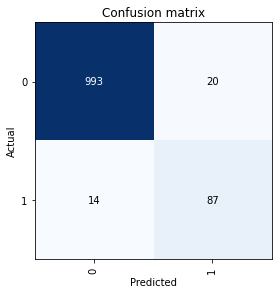

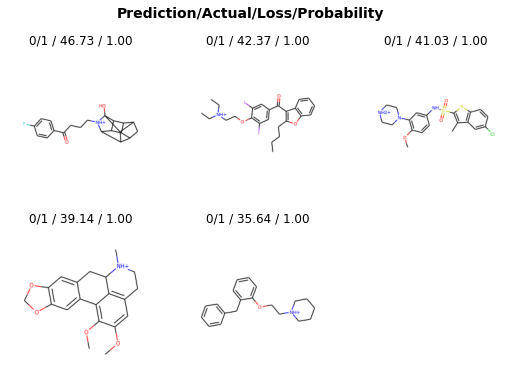

In [21]:
learn = train_on_dataset(datasets[3])
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=5)

Training model on dataset: CHEMBL205_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=11
Weight decay: wd=None
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.559454,0.443545,0.829758,0.489557,0.336395,0.898773,0.931209,0.483728,00:32


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.283761,0.245813,0.923656,0.692825,0.545936,0.947853,0.976195,0.685260,00:41
1,0.236005,0.182197,0.949011,0.762646,0.660674,0.901840,0.967900,0.746017,00:41
2,0.229733,0.156163,0.958484,0.799462,0.712230,0.911043,0.977271,0.784019,00:42
3,0.201066,0.143197,0.954862,0.781081,0.698068,0.886503,0.967549,0.763029,00:42
4,0.168238,0.114659,0.963500,0.819310,0.744361,0.911043,0.977243,0.804287,00:41
5,0.144688,0.118485,0.965171,0.830393,0.744526,0.938650,0.984312,0.818038,00:40
6,0.131094,0.120322,0.963500,0.825566,0.729412,0.950920,0.982293,0.814417,00:41
7,0.092812,0.117435,0.966007,0.833787,0.750000,0.938650,0.981670,0.821485,00:41
8,0.082043,0.105553,0.971023,0.855153,0.783163,0.941718,0.982978,0.843609,00:41
9,0.066112,0.100743,0.972416,0.860759,0.794805,0.938650,0.981755,0.849172,00:41


Training model on dataset: CHEMBL1978_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=11
Weight decay: wd=None
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.774297,0.757846,0.706657,0.354267,0.221328,0.887097,0.858271,0.343752,00:12


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.395229,0.287278,0.896854,0.595989,0.462222,0.838710,0.935146,0.574188,00:16
1,0.325102,0.525419,0.812729,0.481781,0.321622,0.959677,0.960696,0.489804,00:16
2,0.251021,0.176558,0.941478,0.722222,0.634146,0.838710,0.961150,0.698651,00:16
3,0.228446,0.143590,0.953182,0.761194,0.708333,0.822581,0.962467,0.737928,00:16
4,0.178171,0.200373,0.932699,0.717791,0.579208,0.943548,0.976371,0.708268,00:17
5,0.160089,0.246668,0.933431,0.725076,0.579710,0.967742,0.972102,0.719263,00:17
6,0.137503,0.179433,0.951719,0.782895,0.661111,0.959677,0.981607,0.773417,00:17
7,0.085634,0.149858,0.959034,0.804196,0.709877,0.927419,0.980011,0.790485,00:17
8,0.063497,0.132548,0.966350,0.836879,0.746835,0.951613,0.978460,0.825895,00:17
9,0.053483,0.105063,0.972933,0.860377,0.808511,0.919355,0.980147,0.847599,00:17


Training model on dataset: CHEMBL301_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=11
Weight decay: wd=None
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.886228,0.541511,0.778852,0.361266,0.244949,0.687943,0.820105,0.313750,00:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.545735,0.358538,0.843972,0.491597,0.349254,0.829787,0.922846,0.471680,00:18
1,0.434763,0.366771,0.837524,0.503937,0.348774,0.907801,0.944746,0.499392,00:18
2,0.362402,0.271269,0.882656,0.572770,0.428070,0.865248,0.949414,0.556462,00:18
3,0.290735,0.305027,0.878143,0.573363,0.420530,0.900709,0.958221,0.563806,00:18
4,0.253291,0.301317,0.885235,0.604444,0.440129,0.964539,0.977375,0.605914,00:18
5,0.207040,0.108274,0.955513,0.779553,0.709302,0.865248,0.987013,0.759695,00:18
6,0.134253,0.119041,0.956802,0.796353,0.696809,0.929078,0.988456,0.782752,00:18
7,0.090527,0.079879,0.971631,0.843972,0.843972,0.843972,0.981877,0.828369,00:18
8,0.072025,0.083222,0.972921,0.858108,0.819355,0.900709,0.987410,0.844332,00:18
9,0.046887,0.077092,0.975500,0.865248,0.865248,0.865248,0.987818,0.851773,00:18


Training model on dataset: CHEMBL218_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=11
Weight decay: wd=None
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.590107,0.533924,0.754122,0.378248,0.245876,0.819372,0.879177,0.354913,00:39


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.307130,0.283087,0.884588,0.592405,0.437111,0.918848,0.966925,0.585110,00:48
1,0.243226,0.217512,0.912784,0.655985,0.512518,0.910995,0.971538,0.643664,00:48
2,0.244258,0.198343,0.917802,0.667311,0.529141,0.903141,0.975344,0.653116,00:48
3,0.171749,0.145027,0.944325,0.747014,0.638219,0.900524,0.978861,0.730175,00:48
4,0.144568,0.083321,0.972760,0.854962,0.831683,0.879581,0.987045,0.840344,00:48
5,0.108137,0.070056,0.975866,0.866225,0.876676,0.856021,0.987331,0.853037,00:48
6,0.081601,0.075884,0.975149,0.871921,0.823256,0.926702,0.991862,0.860058,00:48
7,0.048105,0.063163,0.978734,0.884565,0.876607,0.892670,0.990992,0.872898,00:48
8,0.032248,0.061686,0.980884,0.896104,0.889175,0.903141,0.993026,0.885611,00:48
9,0.025671,0.061494,0.980884,0.897436,0.879397,0.916230,0.993101,0.887128,00:49


Training model on dataset: CHEMBL240_cl
Architechture: <function resnet18 at 0x7fbf46f9d8c8>
Trained epochs: epochs=11
Weight decay: wd=None
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.936152,0.745784,0.696104,0.284404,0.180934,0.664286,0.780337,0.221647,00:15


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.542485,0.312484,0.872078,0.488312,0.383673,0.671429,0.871934,0.442954,00:18
1,0.438046,0.307091,0.881169,0.541353,0.416988,0.771429,0.905245,0.510025,00:18
2,0.367346,0.333345,0.877922,0.554502,0.414894,0.835714,0.924357,0.533582,00:19
3,0.282803,0.222284,0.916883,0.619048,0.530612,0.742857,0.932903,0.584091,00:19
4,0.245206,0.381935,0.835714,0.495010,0.343490,0.885714,0.926071,0.486173,00:19


KeyboardInterrupt: 

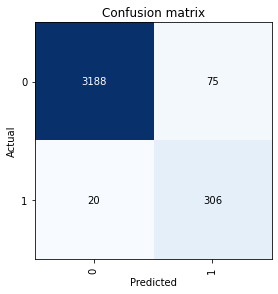

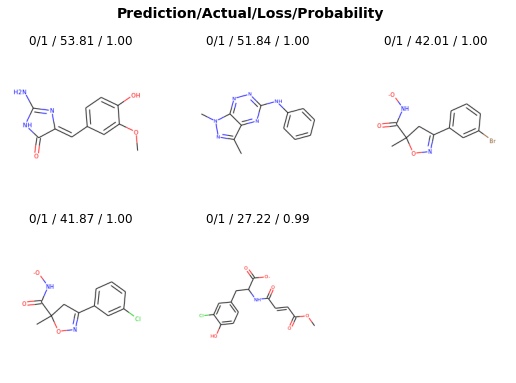

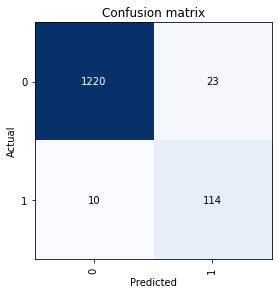

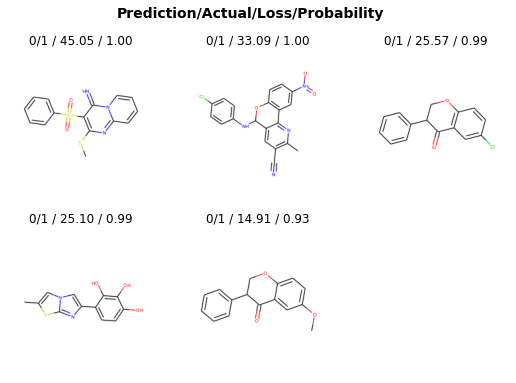

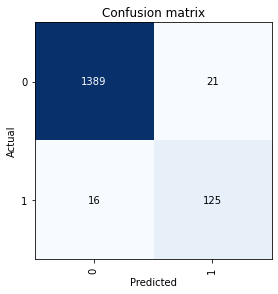

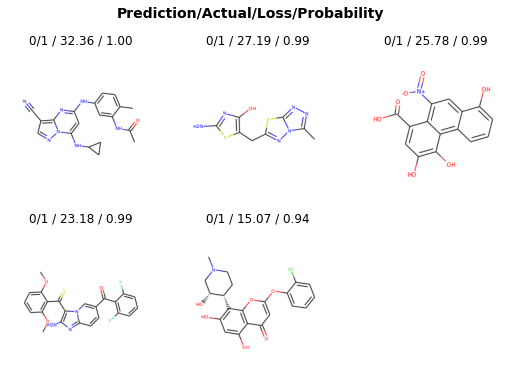

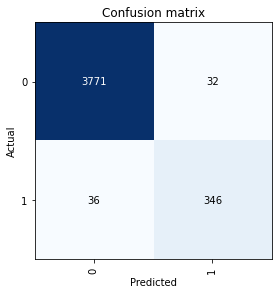

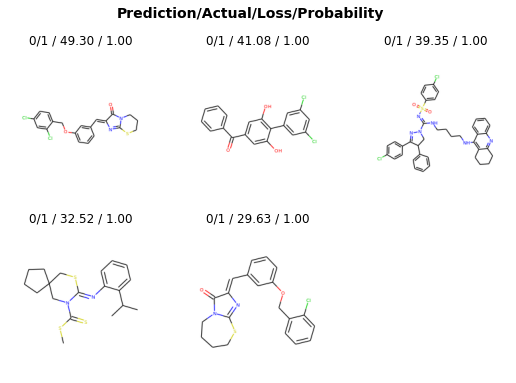

In [38]:
for dataset in datasets: 
    learn = train_on_dataset(dataset)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(k=5)
    

# TODO: Transfer learning

# TODO: Use clustering methods on dataset